In [1]:
import pickle

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch import FloatTensor

# from pfa_model import PFA 
# from pfa_model_new import PFANEW
# from pfa_model_restrict_bestlr import PFARESTRICT
from pfa_model_restrict_bestlr_time import PFARESTRICT
# from pfa_model_noh import PFANOH
# from pfa_time_model import PFATIME

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

In [2]:
def user_state_update(p, target, concepts, categories,  unit2seqs, unit3seqs):
    options = [concepts, categories, unit2seqs, unit3seqs]
    for o in options[:2]: 
        if o is not None: 
            kc = o 
            with open(".datasets/student:{}_kc:{}_info.pkl".format(target, kc), "rb") as f: 
                pd_student = pickle.load(f)
                pd_keys = pd_student[kc].values
                pd_student = pd_student.to_numpy()
            with open(".datasets/kc_{}2idx_name_pfa.pkl".format(kc), "rb") as f:
                kc_info = pickle.load(f)
            with open(".datasets/kc_{}2idx_pfa.pkl".format(kc), "rb") as f:
                kc_idx_info = pickle.load(f)
            # print("kc_idx_info")
            
            result = np.array([])
            for i, key in enumerate(pd_keys):
                reference = int(kc_info[key])
                if reference in kc_idx_info.keys():
                    find_idx = kc_idx_info[reference]
                    if pd_student[i][1] > 0 or pd_student[i][2] > 0: #checking if correct, wrong > 0
                        add_p = p[:, find_idx].squeeze(0).numpy()
                    else:
                        add_p = np.zeros(p.size()[0])
                else:
                    add_p = np.zeros(p.size()[0])
                result = np.append(result, add_p)
            row, col = p.size()[0], int((np.shape(result)[0])/p.size()[0])
            result = result.reshape((col,row))
            merged = np.concatenate((pd_student, result), axis = 1)
            correct_wrong = [kc, "correct", "wrong"]
            problem_info = [str(i)+"prob" for i,m in enumerate(range(row))]
            column_info = correct_wrong + problem_info 
            merged = pd.DataFrame(merged)
            with open(".datasets/student:{}_kc:{}_info.pkl".format(target, kc), "wb") as f:
                pickle.dump(merged, f)
            merged.columns = column_info
            merged.to_excel("student_solved_info/{}/student:{}_kc:{}_info.xlsx".format(kc, target, kc))
            print("checkpoint ",target)
            break

In [3]:
import sys 
from train import main 
import matplotlib.cm as cm
colors = ["r","g","b","c","m","y"]

def run_model(concepts, categories, conditions, skills, unit2seqs, unit3seqs):
    default, save_kc_idx, num_kc = [concepts, categories,conditions, skills, unit2seqs, unit3seqs], {}, 0
    for i, d in enumerate(default): 
        if d is not None: 
            with open(".datasets/kc_{}2idx_pfa.pkl".format(d), "rb") as f:
                save_kc_idx[d] = pickle.load(f)

    num_user, num_kc = 0, 0 
    with open(".datasets/train_user_list_pfa.pkl", "rb") as f: 
        num_user += len(pickle.load(f))
    with open(".datasets/test_user_list_pfa.pkl", "rb") as f: 
        num_user += len(pickle.load(f))
    with open(".datasets/kc_list_pfa.pkl", "rb") as f:
        kc_list = pickle.load(f)
    # for i,k in enumerate(kc_list):
    #     num_kc += len(kc_list[i])
    num_kc = len(kc_list)

    learning_rate = [0.1,0.03,0.05, 0.009,0.0027]
    optimizer = ["SGD", "ADAM"]
    max_iterations = 1
    auc_array_hash, loss_means_array_hash = {}, {}
    
    for idx, opt in enumerate(optimizer):
        loss_means_array = []
        auc_array = []
        for i,r in enumerate(learning_rate):
            for j in range(0,max_iterations):
                main(r, opt)
                with open(".ckpts/loss_means_new_lr={}_opt={}.pkl".format(r, opt), "rb") as f:
                    loss_means = pickle.load(f)
                loss_means_array.insert(i*len(learning_rate)+j,loss_means)
                with open(".ckpts/aucs_new_lr={}_opt={}.pkl".format(r, opt), "rb") as f:
                    auc = pickle.load(f)
                auc_array.insert(i*len(learning_rate)+j,auc)
        loss_means_array = np.array(loss_means_array)
        auc_array = np.array(auc_array)
        auc_array_hash[opt] = auc_array 
        loss_means_array_hash[opt] = loss_means_array
   

    for idx, opt in enumerate(optimizer): 
        auc_array = auc_array_hash[opt]
        loss_means_array = loss_means_array_hash[opt]
        for i,c in zip(range(0,len(learning_rate)),colors):
            auc_temp = auc_array[i*max_iterations:(i+1)*max_iterations]
            plt.title("PFA-restricted_{}".format(list(save_kc_idx.keys())))
            plt.xlabel("Epoch")
            plt.ylabel("Test-AUC")
            plt.plot(np.arange(1,auc_temp.shape[1]+1), np.mean(auc_temp, axis = 0), markerfacecolor = c)
            # plt.fill_between(
            #     np.arange(1,auc_temp.shape[1]+1),
            #     np.mean(auc_temp,axis=0) - np.std(auc_temp,axis=0),
            #     np.mean(auc_temp,axis=0) + np.std(auc_temp,axis=0),
            #     alpha = 0.1,
            #     color = c 
            # )
        plt.legend(learning_rate, title="learning_rate for optimizer_{}".format(opt))
        plt.savefig("pfa-restricted_AUC_optimizer_{}.png".format(opt))
        plt.show()   

        for i,c in zip(range(0,len(learning_rate)),colors):
            loss_temp = loss_means_array[i*max_iterations:(i+1)*max_iterations]
            plt.title("PFA-restricted_{}".format(list(save_kc_idx.keys())))
            plt.xlabel("Epoch")
            plt.ylabel("Test-LOSS")
            plt.plot(np.arange(1,loss_temp.shape[1]+1), np.mean(loss_temp, axis = 0), markerfacecolor = c)
            # plt.fill_between(
            #     np.arange(1,loss_temp.shape[1]+1),
            #     np.mean(loss_temp,axis=0) - np.std(loss_temp,axis=0),
            #     np.mean(loss_temp,axis=0) + np.std(loss_temp,axis=0),
            #     alpha = 0.1,
            #     color = c 
            # )
        plt.legend(learning_rate, title="learning_rate for optimizer_{}".format(opt))
        plt.savefig("pfa-restricted_LOSS_optimizer_{}.png".format(opt))
        plt.show() 

    # save the best state among choices of learning rate 
    default_state = ".ckpts/model_new_aucs={}_lr={}_opt={}.ckpt".format(auc_array_hash["SGD"][0][-1],learning_rate[0],"SGD")
    default_auc = auc_array_hash["SGD"][0][-1]
    for m,n in enumerate(optimizer):
        auc_array = auc_array_hash[n]
        for i in range(1,len(learning_rate)): 
            if auc_array[i][-1] > default_auc: 
                default_auc = auc_array[i][-1]
                default_state = ".ckpts/model_new_aucs={}_lr={}_opt={}.ckpt".format(default_auc,learning_rate[i],n)
    
    print("default state: ", default_state)
    return save_kc_idx, default_state 


In [4]:
def prob_kc_target(target, state, kc_concept2idx, kc_categories2idx, kc_condition2idx, kc_skill2idx, kc_unit2seqs2idx, kc_unit3seqs2idx \
    , concepts, categories, unit2seqs, unit3seqs):
    
    with open(".datasets/preprocessed_data_pfa.pkl", 'rb') as f:
        df = pickle.load(f)
    df_for_oneuser = df[df["username"] == target]

    num_user, num_kc = 0, 0 
    with open(".datasets/train_user_list_pfa.pkl", "rb") as f: 
        num_user += len(pickle.load(f))
    with open(".datasets/test_user_list_pfa.pkl", "rb") as f: 
        num_user += len(pickle.load(f))
    with open(".datasets/kc_list_pfa.pkl", "rb") as f:
        kc_list = pickle.load(f)
        for i,k in enumerate(kc_list):
            num_kc += len(kc_list[i])

    features, indicators, labels  = [], [], []

    total = np.array([kc_concept2idx, kc_categories2idx, kc_condition2idx, kc_skill2idx, kc_unit2seqs2idx, kc_unit3seqs2idx])
    total_bool = np.array([ 1 if t is not None else 0 for t in total])
    
    total_kc = list(filter(lambda x: x is not None, total))
    name = np.array(["concepts", "categories", "conditions", "skills", "unit2seqs", "unit3seqs"])
    total_name = np.array([ name[i] for i,t in enumerate(total_bool) if t is not None ])

    for i in range(len(df_for_oneuser)): 

        kc_save = [df_for_oneuser.iloc[i][total_name[j]] if t == 1  else 0 for j,t in enumerate(total_bool) ]            
        kc_indicator = np.zeros([np.sum(np.array([len(t) for t in total_kc]))])
        
        label = int(df_for_oneuser.iloc[i]["isCorrect"] == "Y")
        track, idx, default_len  = 0, [], np.sum(np.array([len(t) for t in total_kc]))
        feature = np.zeros([2 * default_len])  

        for ii,b in enumerate(total_bool): 
            if b == 1: 
                for k in kc_save[ii]:
                    # print("track: ", track, "total[ii][k]",total[ii][k])
                    kc_indicator[total[ii][k] + track] += 1
                    idx += [total[ii][k] + track + (default_len * label)]
                track += len(total[ii])
        for id in idx:
                feature[id] += 1
        features.append(feature)
        indicators.append(kc_indicator)
        labels.append(label)
    
    features = np.cumsum(features, axis = 0)
    features[1:] = features[:-1]
    features[0] = np.zeros([2 * default_len])

    #adding features for total number of correct answers and wrong answers prior to now attempt
    fail_temp, succ_temp = np.hsplit(features, 2)
    total_fail, total_succ = np.cumsum(fail_temp, axis = 1)[:, -1], np.cumsum(succ_temp, axis = 1)[:, -1]
    total_fail, total_succ = np.array([total_fail]).reshape(np.shape(features)[0], 1), np.array([total_succ]).reshape(np.shape(features)[0], 1)
    fail_temp, succ_temp = np.hstack([fail_temp, total_fail]), np.hstack([succ_temp, total_succ])
    features = np.hstack([fail_temp, succ_temp])
    
    features = np.log(1 + features)
    features = np.hstack([np.vstack(features), indicators])

    #load the model  
    device = torch.device("cpu")
    model = PFARESTRICT(num_user, num_kc)
    model.load_state_dict(torch.load(state, map_location = device))
    model.eval()
    p = model.get_knowledge_state(FloatTensor(features)).detach()
    
    #function 호출해서 target user knowledge state update 해주기 
    temp_p,result_p = p.T, []
    for i in range(0,temp_p.size()[0]):
        result_p += [temp_p[temp_p.size()[0]-i-1]] 
    p_clean = []

    user_state_update(p, target, concepts, categories, unit2seqs, unit3seqs)

    print("Target User: {}".format(target))
    
    plt.figure(figsize=[15, 30], facecolor="white")
    plt.pcolormesh(p.T, cmap="Reds")
    plt.colorbar()
    plt.savefig("pfa_restrict_{}_.png".format(target))
    # plt.show()
    kc_prob_final,kc_prob_initial,temp = [],[], 0
    prob_last_state = p[-1].squeeze(0).numpy()
    prob_first_state = p[0].squeeze(0).numpy()

    for kc_specific in total_kc: 
        temp_kc_prob, temp2_kc_prob = {}, {}
        for key in kc_specific: 
            temp_kc_prob[key] = prob_last_state[temp + kc_specific[key]]
            temp2_kc_prob[key] = prob_first_state[temp + kc_specific[key]]
        kc_prob_final += [temp_kc_prob]
        kc_prob_initial += [temp2_kc_prob]
        temp += len(temp_kc_prob)
    print("kc_prob_final: ", kc_prob_final)
    print("kc_prob_initial: ", kc_prob_initial)
    return target, kc_prob_final, kc_prob_initial, [name[i] for i,u in enumerate(total_bool) if u == 1]

In [5]:
def total_user_knowledge_state(kc_idx, state, concepts, categories, conditions, skills, unit2seqs, unit3seqs): 
    
    df_cbt4 = pd.read_csv(".datasets/cbt4개념지수.xlsx", sep = '\t')
    cbt4_users = np.unique(df_cbt4["학생명"].values)
    bad_user = np.array(['박지원', '윤혜원'])
    cbt4_users = np.array([u for u in cbt4_users if u not in bad_user])

    with open(".datasets/cbt4_user_list_pfa.pkl", "wb") as f:
        pickle.dump(cbt4_users, f)
    with open(".datasets/train_user_list_pfa.pkl" , "rb") as f:
        train_user = pickle.load(f)
    with open(".datasets/test_user_list_pfa.pkl" , "rb") as f:
        test_user = pickle.load(f)

    total_user = list(train_user) + list(test_user)

    name = ["concepts", "categories", "conditions", "skills", "unit2seqs", "unit3seqs"]
    default = [concepts, categories, conditions, skills, unit2seqs, unit3seqs]
    name_hash = {}
    
    for i,n in enumerate(default):
        if n is None: 
            name_hash[name[i]] = None 
        else: 
            name_hash[name[i]] = kc_idx[name[i]]

    for user in cbt4_users: 
        _, kc_prob_final, kc_prob_initial, kc_name_info = prob_kc_target(user, state, name_hash["concepts"], name_hash["categories"], name_hash["conditions"], \
            name_hash["skills"], name_hash["unit2seqs"], name_hash["unit3seqs"], concepts, categories, unit2seqs, unit3seqs)
        with open(".datasets/{}_knowledge_state_final.pkl".format(user), "wb") as f:
            pickle.dump(kc_prob_final, f)
        with open(".datasets/{}_knowledge_state_initial.pkl".format(user), "wb") as f:
            pickle.dump(kc_prob_initial, f)
        with open(".datasets/{}_kc_name_info.pkl".format(user), "wb") as f:
            pickle.dump(kc_name_info, f) 

Here is the learning rate:  0.1 and optimizer:  SGD
Here is the shape of train dataset:  (48857, 890)
Epoch: 1,   AUC: 0.5933749696353575,   Loss Mean: 0.9722997546195984
Epoch: 2,   AUC: 0.5981920153064227,   Loss Mean: 0.7756525278091431
Epoch: 3,   AUC: 0.601071099996564,   Loss Mean: 0.7139130234718323
Epoch: 4,   AUC: 0.6024801575621594,   Loss Mean: 0.6693760752677917
Epoch: 5,   AUC: 0.6049841142762956,   Loss Mean: 0.6367078423500061
Epoch: 6,   AUC: 0.6061019596036726,   Loss Mean: 0.6227141618728638
Epoch: 7,   AUC: 0.6062875413301527,   Loss Mean: 0.6036800146102905
Epoch: 8,   AUC: 0.6074911645197772,   Loss Mean: 0.5995651483535767
Epoch: 9,   AUC: 0.609699824335588,   Loss Mean: 0.5892335772514343
Epoch: 10,   AUC: 0.609717995066211,   Loss Mean: 0.5726186633110046
Epoch: 11,   AUC: 0.6105802487942443,   Loss Mean: 0.5701455473899841
Epoch: 12,   AUC: 0.6124681126203262,   Loss Mean: 0.5709027647972107
Epoch: 13,   AUC: 0.6133628033550919,   Loss Mean: 0.5624860525131226


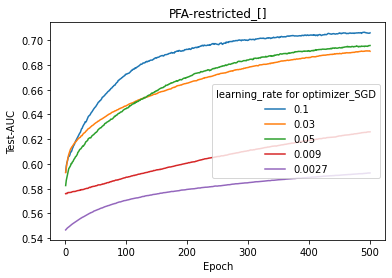

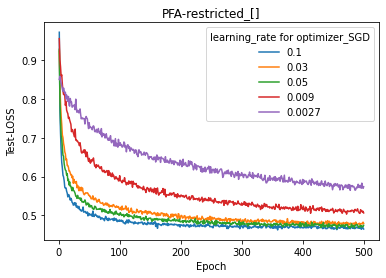

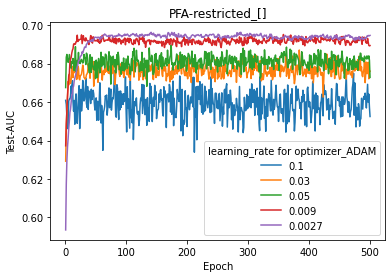

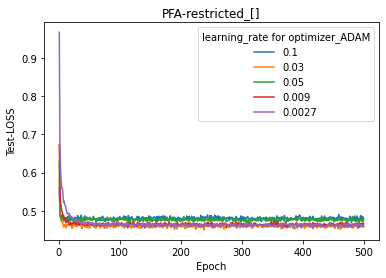

default state:  .ckpts/model_new_aucs=0.7059263672738955_lr=0.1_opt=SGD.ckpt


KeyError: 'concepts'

In [6]:
kc_idx, state = run_model(None, None, None, None, None, None)
# with open(".datasets/kc_categories2idx_pfa.pkl", "rb") as f:
#     kc_idx["categories"] = pickle.load(f)
# state = ".ckpts/model_new_aucs=0.6718085101451556_lr=0.009_opt=Adam.ckpt"
total_user_knowledge_state(kc_idx, state, "concepts", None, None, None, None, None)